<a href="https://colab.research.google.com/github/TGB85/co2_final_assignment/blob/main/co2_question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is the largest predictor of CO2 output per capita?

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# path_var = '/content/drive/MyDrive/Colab Notebooks/co2_emissions/variables/'
path_var = './variables'
# path = '/content/drive/MyDrive/Colab Notebooks/co2_emissions/'
path = './'

In [ ]:
select_col = ['country', 'year','population', 'gdp', 'co2_per_capita', 'trade_co2', 'consumption_co2_per_capita', 'ghg_per_capita', 'energy_per_capita']
df = pd.read_csv('https://github.com/owid/co2-data/blob/master/owid-co2-data.csv?raw=True', usecols=select_col)

In [ ]:
df['country'].unique()
not_countries=['Africa', 'Antarctica', 'Asia', 'Asia (excl. China & India)', 'EU-27', 'Europe (excl. EU-27)', 'Europe (excl. EU-28)', 'European Union (27)', 'European Union (28)', 'High-income countries', 'Low-income countries', 'Lower-middle-income countries', 'North America', 'North America (excl. USA)', 'Oceania', 'South America', 'Upper-middle-income countries', 'World']
df.drop(df[df.country.isin(not_countries)].index.tolist(), inplace=True)
len(df['country'].unique())

230

## different measurements of co2 emissions
* **co2_per_capita** = production-based emissions, not accounting for emissions embedded in trade
* **trade_co2** = annual net co2 emissions embedded in trade (positive when net importer, negative when net exporter)
* **consumption_co2_per_capita** = consumption emissions adjusted for trade: production emissions minus emissions embedded in exports, plus emissions embedded in imports
* **ghg_per_capita** = total greenhouse gas emissions including land-use change and forestry

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22634 entries, 0 to 25988
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     22634 non-null  object 
 1   year                        22634 non-null  int64  
 2   co2_per_capita              21049 non-null  float64
 3   trade_co2                   3584 non-null   float64
 4   consumption_co2_per_capita  3584 non-null   float64
 5   ghg_per_capita              5593 non-null   float64
 6   population                  21818 non-null  float64
 7   gdp                         13453 non-null  float64
 8   energy_per_capita           9132 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
df['trade'] = df.trade_co2 / df.population
df.drop(columns=['trade_co2'], inplace=True)

In [ ]:
df.rename(columns={'co2_per_capita': 'production', 'consumption_co2_per_capita': 'consumption', 'ghg_per_capita': 'ghg', 'energy_per_capita': 'energy'}, inplace=True)
df.describe() 

,year,production,consumption,ghg,population,gdp,energy,trade
count,22634.000000,21049.000000,3584.000000,5593.000000,2.181800e+04,1.345300e+04,9132.000000,3.584000e+03
mean,1957.931828,4.249665,6.591445,7.609890,2.679972e+07,2.433303e+11,24552.216698,5.198128e-07
std,49.561894,15.639212,7.190372,8.309019,9.994971e+07,9.736959e+11,32324.348660,3.507951e-06
min,1750.000000,0.000000,0.055000,-31.485000,1.490000e+03,5.543200e+07,0.000000,-3.441228e-05
25%,1933.000000,0.241000,1.115000,2.638000,1.165106e+06,9.762129e+09,2970.163000,-7.006920e-09
50%,1970.000000,1.189000,4.184500,5.331000,4.462386e+06,3.037392e+10,12766.360500,1.824700e-07
75%,1996.000000,4.657000,9.887000,9.675000,1.426995e+07,1.269087e+11,34021.109500,1.000928e-06
max,2020.000000,748.639000,57.792000,74.729000,1.439324e+09,1.815162e+13,308704.252000,3.163920e-05


In [ ]:
# find year with least null values
def year_most_values(df, min_year, max_year):
  null_val_year = {}
  for i in range(min_year, max_year+1):
    null_val_year[i] = df.loc[df['year'] == i].isnull().mean().sum()
  return min(null_val_year, key=null_val_year.get)

# df.loc[~df['consumption'].isnull(), 'year'].unique() # not null for years 1990-2019

year_most_values(df, 1990, 2019) # 2007

2007

In [ ]:
df2 = df.loc[df['year'] == 2007, ['production', 'trade', 'consumption', 'ghg']].copy()

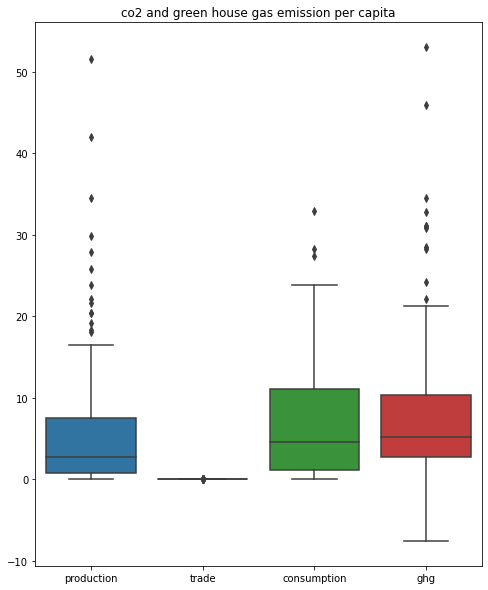

In [ ]:
fig, ax = plt.subplots(figsize=(8,10))
sns.boxplot(data=df2)
_ = ax.set(title='co2 and green house gas emission per capita')

In [ ]:
# (df2.isnull().mean() * 100).plot(kind='bar')

## variables

In [ ]:
# vehicle data only for 2014 
df2014 = df.loc[df['year'] == 2014, ['year', 'country', 'consumption', 'gdp', 'population', 'energy']].copy()
# data on diet and crops yields only for in 2013
df2013 = df.loc[df['year'] == 2013, ['year', 'country', 'consumption', 'gdp', 'population', 'energy']].copy()

In [ ]:
def merge_var(df, path_var):
  variables = {}
  for filename in os.listdir(path_var):
    # print(filename)
    if filename not in variables:
      file = pd.read_csv(os.path.join(path_var, filename))
      # print(file.columns[-1])
      variables[filename] = file.columns[-1]
      file.columns = ['country', 'code', 'year', filename.split('.')[0]]
      # print(file.columns)
      file.drop(columns=['code'], inplace=True)
      # print(file.columns)
      df = pd.merge(df, file, how='left', on=['country', 'year'])
  return df, variables

### 2014

In [ ]:
merged_2014, variables = merge_var(df2014, path_var)

In [ ]:
variables # renewable, electricity & urban are percentages

{'air.csv': 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
 'arg_land.csv': 'agricultural_land_per_capita',
 'coal.csv': 'Coal per capita (kWh)',
 'electricity.csv': 'Access to electricity (% of population)',
 'fertilizers.csv': 'Fertilizers indicators - Nutrient nitrogen N (total) - 3102 - Use per area of cropland - 5159 - kg/ha',
 'gas.csv': 'Gas per capita (kWh)',
 'internet.csv': 'Number of internet users (OWID based on WB & UN)',
 'meat.csv': 'Livestock Primary - Meat, Total - 1765 - Production - 5510 - tonnes',
 'milk.csv': 'Livestock Primary - Milk, Total - 1780 - Production - 5510 - tonnes',
 'oil.csv': 'Oil per capita (kWh)',
 'renewable.csv': 'Renewables (% sub energy)',
 'urban.csv': 'Urban population (% of total population)',
 'veg.csv': 'Vegetables - Food supply quantity (kg/capita/yr) (FAO, 2020)',
 'vehicle.csv': 'Motor vehicles per 1000 people (NationMaster (2014))'}

<AxesSubplot:>

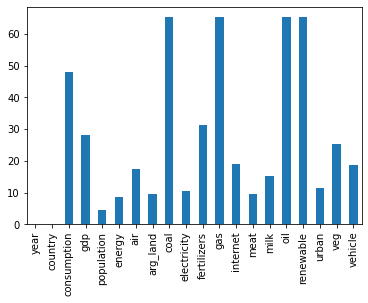

In [ ]:
(merged_2014.isnull().mean() * 100).plot(kind='bar')

In [ ]:
# percentages to continous values
merged_2014.urban = (merged_2014.urban/100000) * merged_2014.population # urban population per 1000 people
merged_2014.electricity = (merged_2014.electricity/100000) * merged_2014.population # per 1000
merged_2014.renewable = (merged_2014.renewable/100) * merged_2014.energy # renewable energy per capita, measured in kilowatt-hours per year

In [ ]:
merged_2014.gdp = merged_2014.gdp/merged_2014.population # gdp per capita
merged_2014.milk = (merged_2014.milk*1000)/merged_2014.population # milk production per 1000 people
merged_2014.drop(columns=['population'], inplace=True)

In [ ]:
merged_2014.energy = merged_2014.energy / 1000

In [ ]:
merged_2014.describe()

,year,consumption,gdp,energy,air,arg_land,coal,electricity,fertilizers,gas,internet,meat,milk,oil,renewable,urban,veg,vehicle
count,230.0,120.000000,165.000000,210.000000,190.000000,208.000000,80.00000,2.050000e+02,158.000000,80.000000,1.860000e+02,2.080000e+02,195.000000,80.000000,80.000000,204.000000,172.000000,187.000000
mean,2014.0,6.667225,17869.562390,25.677934,26.838584,1.234011,5377.99925,3.035315e+04,59.064810,13805.780087,1.538050e+07,1.829348e+06,160.377482,16973.805112,5967.324840,19015.379194,87.009709,208.326203
std,0.0,6.654818,19457.340880,33.320700,16.316752,3.447981,6996.94480,1.277639e+05,63.316669,25573.008530,5.706112e+07,8.119840e+06,374.239896,19529.744625,17631.056076,66093.631317,66.261081,217.254708
min,2014.0,0.075000,663.271625,0.000000,6.180830,0.000119,0.00000,1.021779e+01,0.000000,0.000000,1.353100e+04,2.000000e+00,0.008410,462.681000,0.788345,5.327155,7.310000,2.000000
25%,2014.0,1.428000,4298.446720,4.007049,14.894882,0.162298,581.73725,6.891011e+02,9.130000,2612.631750,4.303142e+05,2.786925e+04,13.198550,6294.323250,425.599013,703.205402,40.670000,29.000000
50%,2014.0,4.944000,11590.846608,15.504797,22.998819,0.381328,2786.53450,4.567522e+03,43.345000,7043.133000,2.517468e+06,2.109965e+05,61.809693,12610.580000,1865.967233,3739.095058,68.950000,125.000000
75%,2014.0,9.409250,23680.133144,32.590138,33.799157,0.892668,6566.23325,1.681202e+04,81.982500,11349.741750,7.569811e+06,7.544868e+05,194.616433,18622.547000,4256.130293,11008.678279,111.187500,340.500000
max,2014.0,41.975000,145253.355806,210.989368,98.116020,38.665927,37339.82000,1.399454e+06,377.970000,156286.743000,6.658629e+08,8.801100e+07,4667.676478,138510.828000,140335.744542,759329.727412,406.590000,797.000000


<AxesSubplot:>

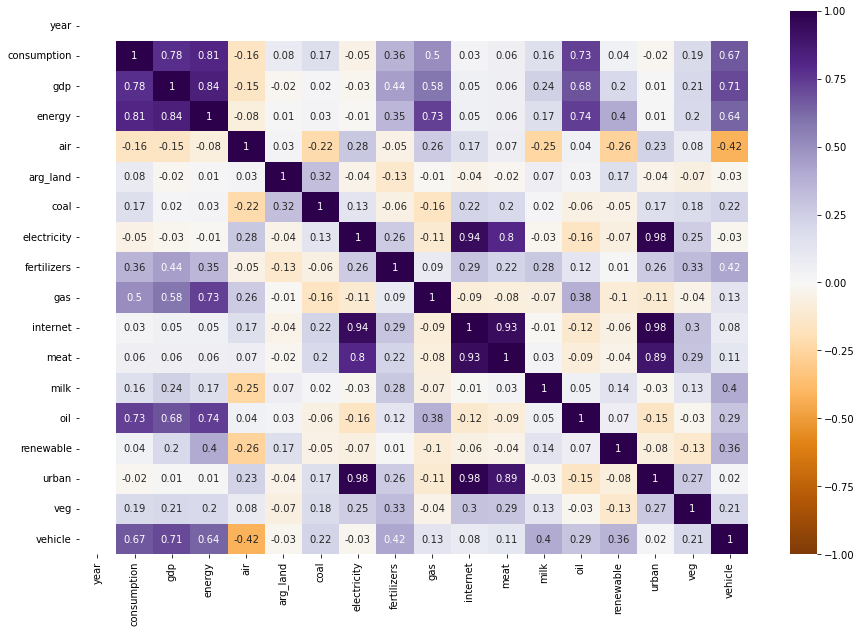

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(merged_2014.corr().round(2), annot=True, cmap='PuOr', vmin=-1, center=0, vmax=1)
# fig.savefig('pearson_2014.jpg')

In [ ]:
# meat production & internet use have a strong (>.89) correlation with gdp
# electricity is strongly related with urban (.98)
merged_2014.drop(columns=['meat', 'internet', 'electricity'], inplace=True)

<AxesSubplot:>

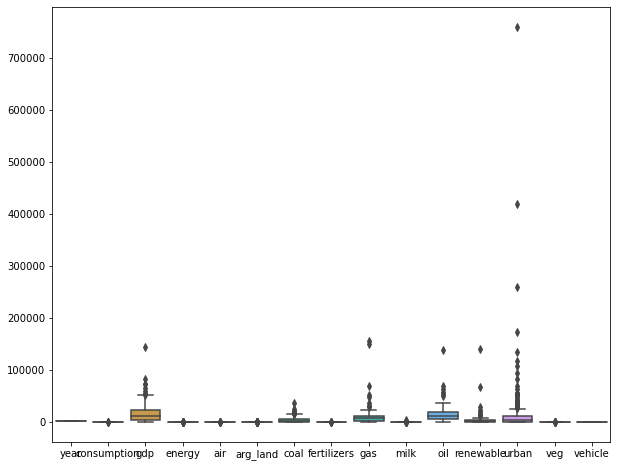

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=merged_2014)

In [ ]:
# merged_2014.sort_values(by='urban', ascending=False) 
# outliers: Singapore for oil, Qatar for gdp, Qatar & Trinidad and Tobago for gas, China & India for electricity, same for urban

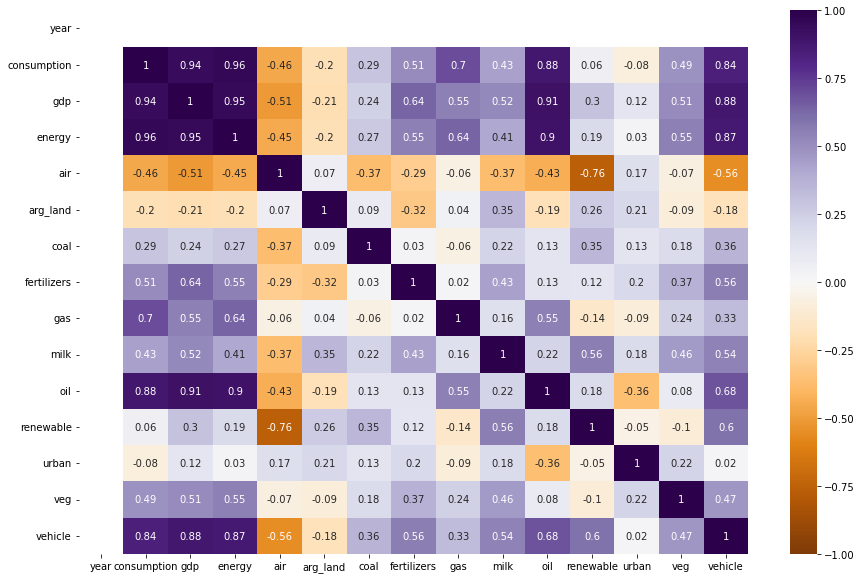

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(merged_2014.corr(method='spearman').round(2), annot=True, cmap='PuOr', vmin=-1, center=0, vmax=1)
# fig.savefig('spearman_2014.jpg')
# energy (.95) and oil (.91) related to gdp; oil and energy (.9); vehicle and energy (.87)

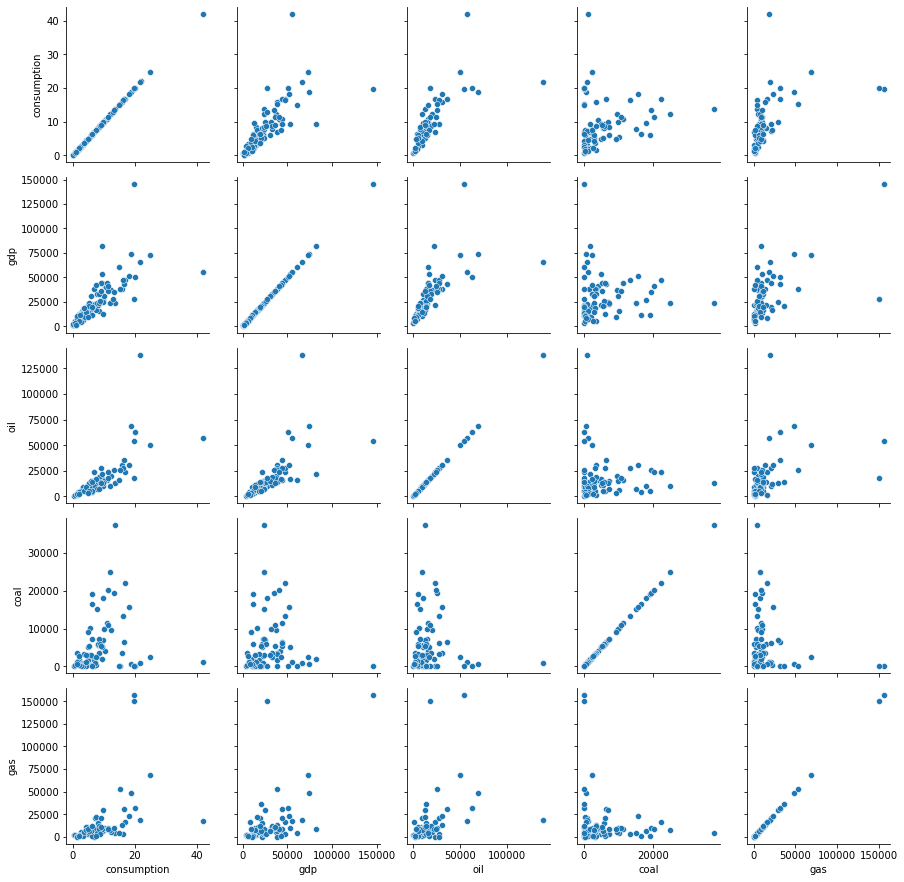

In [ ]:
g = sns.PairGrid(merged_2014, vars=['consumption', 'gdp', 'oil', 'coal', 'gas']) 
g.map(sns.scatterplot)

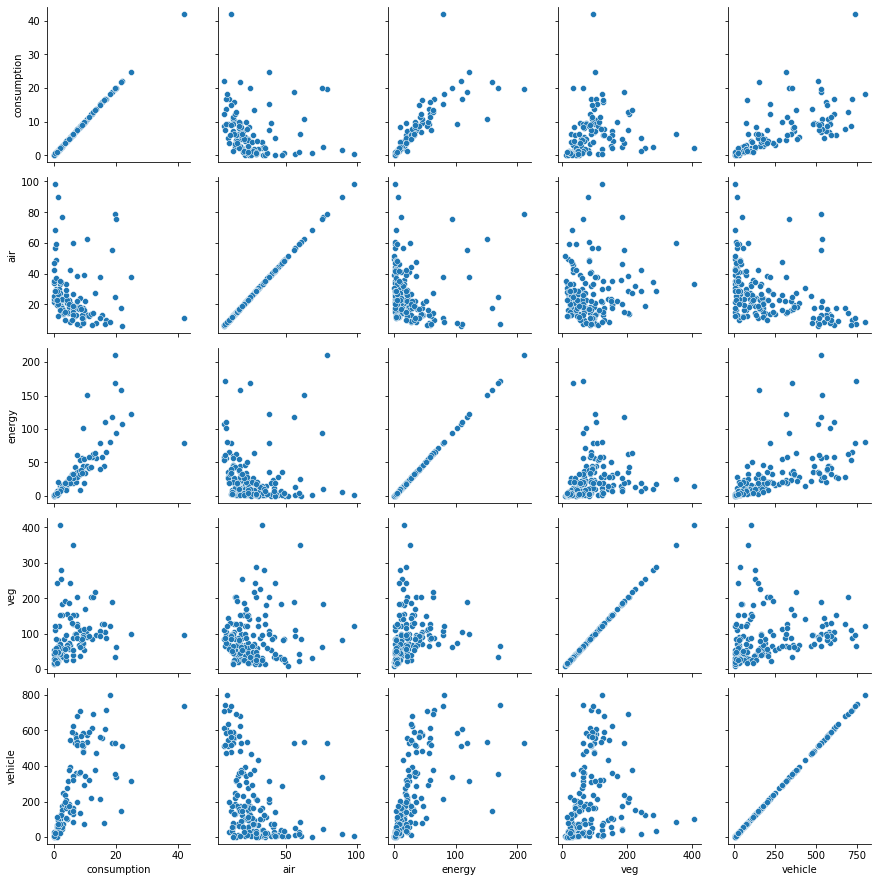

In [ ]:
g = sns.PairGrid(merged_2014, vars=['consumption', 'air', 'energy', 'veg', 'vehicle'])
g.map(sns.scatterplot)

C:\Users\tammi\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


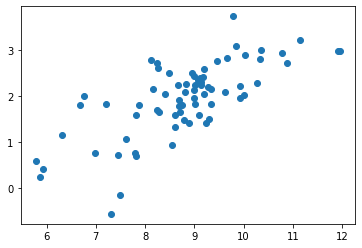

In [ ]:
x = merged_2014.gas # log
# x = merged_2014.air # -log
# x = merged_2014.vehicle # linear
# x = merged_2014.energy # log
y = merged_2014.consumption
log_y = np.log(y)
log_x = np.log(x)
plt.scatter(log_x, log_y)

In [ ]:
merged_2014.consumption.isnull().mean() # 47.8%

0.4782608695652174

In [ ]:
# dropping rows
merged_2014.dropna(subset=['consumption'], inplace=True)

In [ ]:
# model1 = gdp + gas + coal; adj_r_squared = 89.4, BIC 20.84
model1 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+gas+coal)', data=merged_2014).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(consumption)   R-squared:                       0.896
Model:                             OLS   Adj. R-squared:                  0.894
Method:                  Least Squares   F-statistic:                     619.1
Date:                 Tue, 19 Jul 2022   Prob (F-statistic):           4.31e-37
Time:                         17:57:35   Log-Likelihood:                -6.1173
No. Observations:                   74   AIC:                             16.23
Df Residuals:                       72   BIC:                             20.84
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -6.5344      0.341    -19.137      0.000      -7.215      -5.854
np.log(oil + gas + coal)     0.8357      0.034     24.882      0.000       0.769       0.903
==============================================================================
Omnibus:                       17.394   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.393
Skew:                           0.764   Prob(JB):                     2.06e-08
Kurtosis:                       6.023   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# model2 = model1 + veg + air; adj_r_squared: 93.0, BIC -2.37
model2 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+gas+coal) + np.log(veg) + np.log(air)', data=merged_2014).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(consumption)   R-squared:                       0.933
Model:                             OLS   Adj. R-squared:                  0.930
Method:                  Least Squares   F-statistic:                     300.2
Date:                 Tue, 19 Jul 2022   Prob (F-statistic):           5.16e-38
Time:                         17:57:35   Log-Likelihood:                 9.6546
No. Observations:                   69   AIC:                            -11.31
Df Residuals:                       65   BIC:                            -2.373
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -6.2285      0.387    -16.078      0.000      -7.002      -5.455
np.log(oil + gas + coal)     0.8184      0.033     25.159      0.000       0.753       0.883
np.log(veg)                  0.1002      0.051      1.949      0.056      -0.002       0.203
np.log(air)                 -0.1967      0.044     -4.478      0.000      -0.284      -0.109
==============================================================================
Omnibus:                       35.249   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.504
Skew:                           1.573   Prob(JB):                     4.07e-22
Kurtosis:                       7.936   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# model3 = model2 + vehicle, adj_r_squared 93.4, BIC -3.90
model3 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+gas+coal) + np.log(veg) + np.log(air) + np.log(vehicle)', data=merged_2014).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(consumption)   R-squared:                       0.938
Model:                             OLS   Adj. R-squared:                  0.934
Method:                  Least Squares   F-statistic:                     242.4
Date:                 Tue, 19 Jul 2022   Prob (F-statistic):           6.79e-38
Time:                         17:57:35   Log-Likelihood:                 12.534
No. Observations:                   69   AIC:                            -15.07
Df Residuals:                       64   BIC:                            -3.897
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -6.2197      0.374    -16.609      0.000      -6.968      -5.472
np.log(oil + gas + coal)     0.7286      0.049     14.756      0.000       0.630       0.827
np.log(veg)                  0.0755      0.051      1.486      0.142      -0.026       0.177
np.log(air)                 -0.0878      0.063     -1.401      0.166      -0.213       0.037
np.log(vehicle)              0.1242      0.053      2.360      0.021       0.019       0.229
==============================================================================
Omnibus:                       36.960   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.706
Skew:                           1.609   Prob(JB):                     2.04e-25
Kurtosis:                       8.403   Cond. No.                         190.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
anova1 = anova_lm(model1, model2)
anova2 = anova_lm(model1, model3)
anova3 = anova_lm(model2, model3)
display(anova1, anova2, anova3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,72.0,5.111647,0.0,NaN,NaN,NaN
1,65.0,3.053797,7.0,2.05785,6.257328,0.000013


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,72.0,5.111647,0.0,NaN,NaN,NaN
1,64.0,2.809298,8.0,2.30235,6.556371,0.000003


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,65.0,3.053797,0.0,NaN,NaN,NaN
1,64.0,2.809298,1.0,0.244499,5.570059,0.02133


In [ ]:
merged_2014.drop(columns=['country', 'year'], inplace=True)
merged_2014.columns

Index(['consumption', 'gdp', 'energy', 'air', 'arg_land', 'coal',
       'fertilizers', 'gas', 'milk', 'oil', 'renewable', 'urban', 'veg',
       'vehicle'],
      dtype='object')

In [ ]:
# test & train indices
indices = range(len(merged_2014))
s = int(0.8*len(indices))
train_ind = np.random.choice(indices, size=s, replace=False)
test_ind = list(set(indices) - set(train_ind))

In [ ]:
train_2014 = merged_2014.iloc[train_ind]
test_2014 = merged_2014.iloc[test_ind]

In [ ]:
len(train_2014)

96

In [ ]:
# model 1
model1 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+gas+coal)', data=train_2014).fit()
predict1 = model1.predict(test_2014)
fitted1 = model1.predict(merged_2014)
rmse1 = np.mean((merged_2014.consumption-predict1)**2)**.5
mae1 = np.mean(np.abs(merged_2014.consumption - fitted1))

In [ ]:
# model 2
model2 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+gas+coal)  + np.log(veg) + np.log(air)', data=train_2014).fit()
predict2 = model2.predict(test_2014)
fitted2 = model2.predict(merged_2014)
rmse2 = np.mean((merged_2014.consumption - predict2)**2)**.5
mae2 = np.mean(np.abs(merged_2014.consumption - fitted2))

In [ ]:
# model 3
model3 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+gas+coal)  + np.log(veg) + np.log(air) + np.log(vehicle)', data=train_2014).fit()
predict3 = model3.predict(test_2014)
fitted3 = model3.predict(merged_2014)
rmse3 = np.mean((merged_2014.consumption - predict3)**2)**.5
mae3 = np.mean(np.abs(merged_2014.consumption - fitted3))

In [ ]:
f'Model 1: rmse {rmse1}, mae {mae1}', f'Model 2: rmse {rmse2}, mae {mae2}', f'Model 3: rmse {rmse3}, mae {mae3}'

('Model 1: rmse 9.938751925731172, mae 7.140626569854688',
 'Model 2: rmse 9.059821635409422, mae 6.733894709677947',
 'Model 3: rmse 9.093633970754167, mae 6.7391097091320225')

In [ ]:
# model2 residuals
residuals = merged_2014.consumption - fitted2

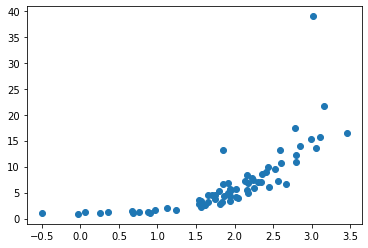

In [ ]:
plt.scatter(fitted2, residuals)

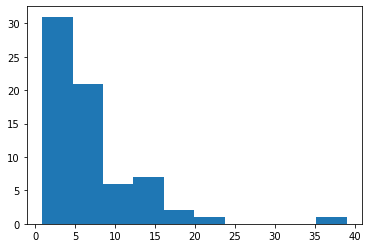

In [ ]:
plt.hist(residuals)
plt.show()

### 2013

In [ ]:
# diet = kcal per person per day
diet = pd.read_csv(os.path.join(path, 'diet.csv'))
diet['kcal'] = diet.iloc[:, 3:].sum(axis=1)
diet.drop(diet.iloc[:, 3:-1], inplace=True, axis=1)
diet.drop(columns=['Code'], inplace=True)
diet.columns = ['country', 'year', 'kcal']

In [ ]:
# crop yields = Yield - 5419 - hg/ha
crops = pd.read_csv(os.path.join(path, 'crops.csv'))
crops.drop(columns=['Code'], inplace=True)
crops.drop(crops.iloc[:, 7:], inplace=True, axis=1)
crops.isnull().mean()
crops.columns = ['country', 'year', 'wheat', 'rice', 'maize', 'soy', 'potato']

In [ ]:
# merge df2013 with diet & crop
df2013 = pd.merge(df2013, diet, how='left', on=['country', 'year'])
df2013 = pd.merge(df2013, crops, how='left', on=['country', 'year'])
merged_2013, _ = merge_var(df2013, path_var)

In [ ]:
merged_2013.drop(columns=['country', 'year'], inplace=True)

<AxesSubplot:>

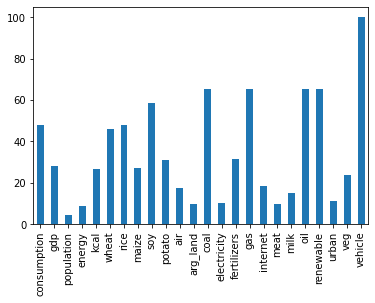

In [ ]:
(merged_2013.isnull().mean() * 100).plot(kind='bar')

In [ ]:
# meat production & internet use have a strong (>.89) correlation with gdp
merged_2013.drop(columns=['meat', 'internet'], inplace=True)
# vehile is empty for 2013
merged_2013.drop(columns=['vehicle'], inplace=True)

In [ ]:
# percentages to continous values
merged_2013.urban = (merged_2013.urban/100000) * merged_2013.population # urban population per 1000 people
merged_2013.electricity = (merged_2013.electricity/100000) * merged_2013.population # per 1000
merged_2013.renewable = (merged_2013.renewable/100) * merged_2013.energy # renewable energy per capita, measured in kilowatt-hours per year

In [ ]:
merged_2013.energy = merged_2013.energy/1000

In [ ]:
merged_2013.gdp = merged_2014.gdp/merged_2013.population # gdp per capita
merged_2013.milk = (merged_2014.milk*1000)/merged_2013.population # milk production per 1000 people
merged_2013.drop(columns=['population'], inplace=True)

In [ ]:
merged_2013.describe()

,consumption,gdp,energy,kcal,wheat,rice,maize,soy,potato,air,arg_land,coal,electricity,fertilizers,gas,milk,oil,renewable,urban,veg
count,120.000000,118.000000,210.000000,169.000000,124.000000,120.000000,168.000000,95.000000,159.000000,190.000000,208.000000,80.000000,2.050000e+02,158.000000,80.000000,119.000000,80.000000,80.000000,204.000000,175.000000
mean,6.765033,0.005029,25.773282,2850.727811,3.253291,3.946927,4.819709,1.674018,19.619360,27.871745,1.254181,5516.524287,2.981928e+04,58.532848,14049.579850,0.047601,17191.570187,5894.771332,18633.759210,90.261314
std,6.812688,0.013007,33.297524,439.244938,1.952922,2.118863,4.984964,0.790110,10.110775,16.890705,3.516203,7070.217590,1.253087e+05,61.533080,25308.829201,0.147277,19474.094242,17654.701503,64476.714433,65.396141
min,0.072000,0.000004,0.000000,1879.000000,0.400000,0.282400,0.084900,0.333600,1.181800,6.278689,0.000123,0.000000,1.012934e+01,0.000000,0.000000,0.000001,416.816000,0.000000,5.294980,7.730000
25%,1.416250,0.000197,3.945573,2529.000000,1.829475,2.275125,1.685825,1.070800,13.460850,15.386381,0.165380,527.925000,6.527614e+02,9.582500,3360.965500,0.001093,5946.953500,428.636256,681.798076,43.280000
50%,5.206000,0.000791,15.152745,2830.000000,2.780800,3.772900,3.316750,1.635600,18.152200,23.923449,0.393128,2734.639500,4.615426e+03,43.515000,7322.678000,0.004850,12465.584000,1991.704026,3657.711501,71.720000
75%,9.821000,0.004255,33.875443,3193.000000,4.115625,5.311675,6.388000,2.163800,25.382600,33.886910,0.910082,7305.784000,1.606161e+04,81.785000,11255.758500,0.024194,19468.907500,4296.381079,10871.111382,114.025000
max,44.859000,0.102189,205.627741,3768.000000,9.105300,10.217700,36.761900,4.160900,48.440400,95.313988,39.569240,36934.485000,1.391842e+06,364.860000,150986.862000,1.062849,136784.055000,141734.154386,737879.112384,353.140000


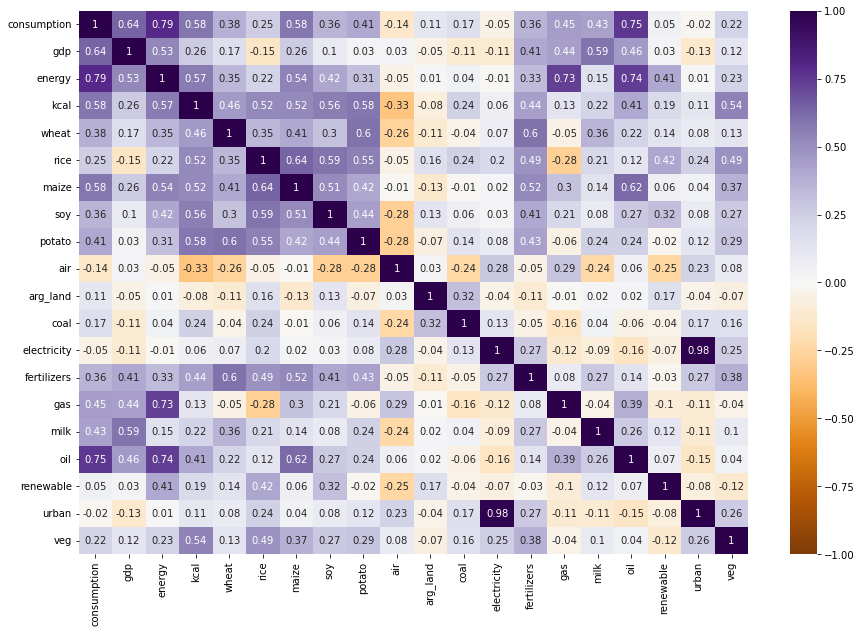

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(merged_2013.corr().round(2), annot=True, cmap='PuOr', vmin=-1, center=0, vmax=1)
# fig.savefig('pearson_2013.jpg')

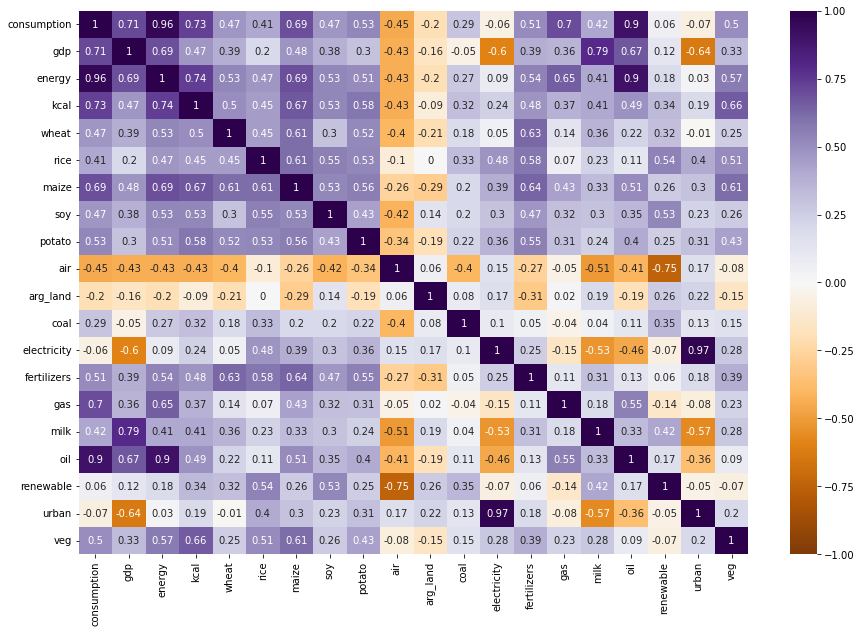

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(merged_2013.corr(method='spearman').round(2), annot=True, cmap='PuOr', vmin=-1, center=0, vmax=1)
# fig.savefig('spearman_2013.jpg')
# electricity-urban (.97), energy-oil(.9)

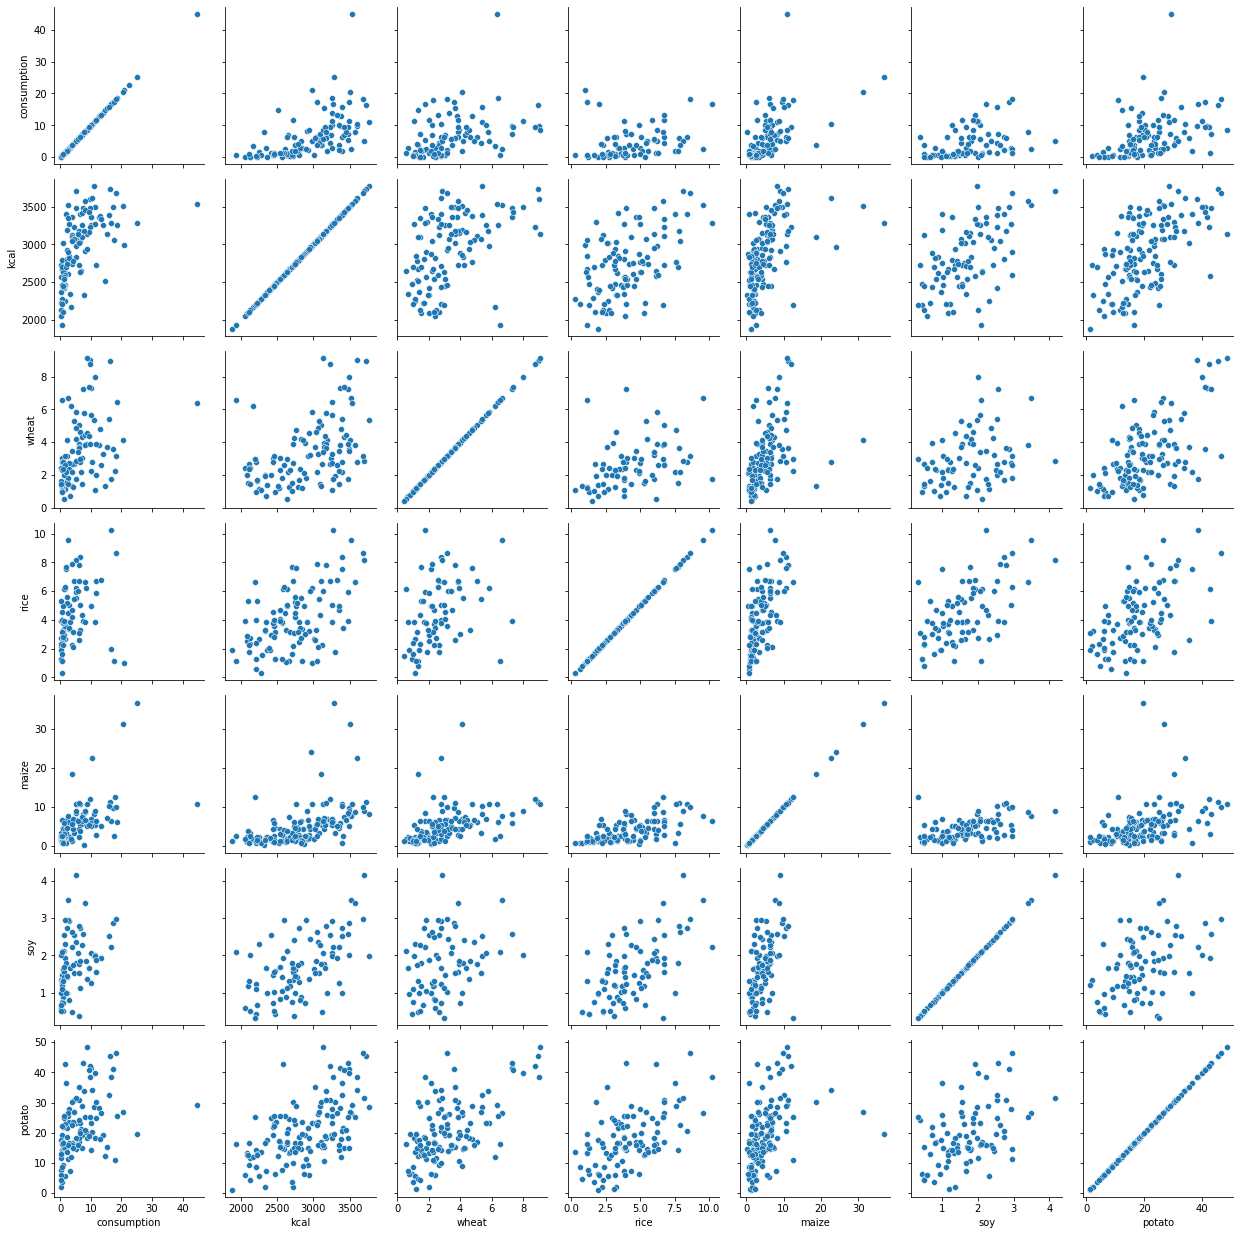

In [ ]:
g = sns.PairGrid(merged_2013, vars=['consumption', 'kcal', 'wheat', 'rice', 'maize', 'soy', 'potato']) 
g.map(sns.scatterplot)

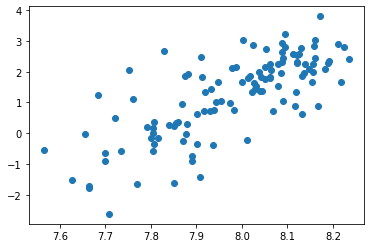

In [ ]:
# x = merged_2013.maize
x = merged_2013.kcal
x_log = np.log(x)
y = merged_2013.consumption
y_log = np.log(y)
plt.scatter(x_log, y_log)

In [ ]:
# model4 = model 2 + milk; r_sq_adj 93.5, BIC -2.00
model4 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+gas+coal) + np.log(veg) + np.log(air) + np.log(milk)', data=merged_2013).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(consumption)   R-squared:                       0.939
Model:                             OLS   Adj. R-squared:                  0.935
Method:                  Least Squares   F-statistic:                     245.0
Date:                 Tue, 19 Jul 2022   Prob (F-statistic):           4.94e-38
Time:                         17:59:24   Log-Likelihood:                 11.589
No. Observations:                   69   AIC:                            -13.18
Df Residuals:                       64   BIC:                            -2.007
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -5.9366      0.384    -15.467      0.000      -6.703      -5.170
np.log(oil + gas + coal)     0.7919      0.033     23.993      0.000       0.726       0.858
np.log(veg)                  0.0929      0.051      1.836      0.071      -0.008       0.194
np.log(air)                 -0.1470      0.050     -2.957      0.004      -0.246      -0.048
np.log(milk)                 0.0273      0.013      2.160      0.035       0.002       0.053
==============================================================================
Omnibus:                       21.710   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.093
Skew:                           1.027   Prob(JB):                     2.66e-10
Kurtosis:                       6.334   Cond. No.                         190.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# model5 = model2 + crop yields; r_sq_adj 97.8, BIC -38.50
model5 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+coal+gas) + np.log(veg) + np.log(air) + np.log(potato+wheat+rice)', data=merged_2013).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(consumption)   R-squared:                       0.981
Model:                             OLS   Adj. R-squared:                  0.978
Method:                  Least Squares   F-statistic:                     375.7
Date:                 Tue, 19 Jul 2022   Prob (F-statistic):           1.59e-24
Time:                         18:00:42   Log-Likelihood:                 28.067
No. Observations:                   34   AIC:                            -46.13
Df Residuals:                       29   BIC:                            -38.50
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -7.1323      0.426    -16.732      0.000      -8.004      -6.261
np.log(oil + coal + gas)          0.8833      0.038     23.046      0.000       0.805       0.962
np.log(veg)                       0.0323      0.036      0.886      0.383      -0.042       0.107
np.log(air)                      -0.1072      0.044     -2.442      0.021      -0.197      -0.017
np.log(potato + wheat + rice)     0.0672      0.063      1.064      0.296      -0.062       0.196
==============================================================================
Omnibus:                        1.738   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.372
Skew:                           0.301   Prob(JB):                        0.504
Kurtosis:                       2.222   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# model6 = oil+gas+coal + air + milk + crop yields; r_sq_adj 97.8, BIC -37.63
model6 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+coal+gas) + np.log(air) + np.log(milk) + np.log(potato+wheat+rice)', data=merged_2013).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(consumption)   R-squared:                       0.981
Model:                             OLS   Adj. R-squared:                  0.978
Method:                  Least Squares   F-statistic:                     366.0
Date:                 Tue, 19 Jul 2022   Prob (F-statistic):           2.30e-24
Time:                         18:01:09   Log-Likelihood:                 27.632
No. Observations:                   34   AIC:                            -45.26
Df Residuals:                       29   BIC:                            -37.63
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -7.2622      0.419    -17.319      0.000      -8.120      -6.405
np.log(oil + coal + gas)          0.9032      0.032     28.168      0.000       0.838       0.969
np.log(air)                      -0.0868      0.052     -1.657      0.108      -0.194       0.020
np.log(milk)                      0.0029      0.016      0.181      0.858      -0.030       0.035
np.log(potato + wheat + rice)     0.0776      0.065      1.199      0.240      -0.055       0.210
==============================================================================
Omnibus:                        1.317   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                1.179
Skew:                           0.293   Prob(JB):                        0.555
Kurtosis:                       2.301   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
anova4 = anova_lm(model4, model5)
anova5 = anova_lm(model4, model6)
anova6 = anova_lm(model5, model6)
display(anova4, anova5, anova6)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,64.0,2.887319,0.0,NaN,NaN,NaN
1,29.0,0.381938,35.0,2.505381,5.435142,0.000006


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,64.0,2.887319,0.0,NaN,NaN,NaN
1,29.0,0.391837,35.0,2.495482,5.276902,0.000008


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,29.0,0.381938,0.0,NaN,NaN,NaN
1,29.0,0.391837,-0.0,-0.009899,inf,NaN


In [ ]:
indices = range(len(merged_2014))
s = int(0.8*len(indices))
train_ind = np.random.choice(indices, size=s, replace=False)
test_ind = list(set(indices) - set(train_ind))
train_2013 = merged_2013.iloc[train_ind]
test_2013 = merged_2013.iloc[test_ind]

In [ ]:
len(train_2013)

96

In [ ]:
model4 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+coal+gas) + np.log(veg) + np.log(air) + np.log(milk)', data=train_2013).fit()
predict4 = model4.predict(test_2013)
fitted4 = model4.predict(merged_2013)
rmse4 = np.mean((merged_2013.consumption-predict4)**2)**.5
mae4 = np.mean(np.abs(merged_2013.consumption - fitted4))

In [ ]:
model5 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+coal+gas) + np.log(veg) + np.log(air) + np.log(potato+wheat+rice)', data=train_2013).fit()
predict5 = model5.predict(test_2013)
fitted5 = model5.predict(merged_2013)
rmse5 = np.mean((merged_2013.consumption-predict5)**2)**.5
mae5 = np.mean(np.abs(merged_2013.consumption - fitted5))

In [ ]:
model6 = sm.OLS.from_formula('np.log(consumption) ~ np.log(oil+coal+gas) + np.log(air) + np.log(potato+wheat+rice) + np.log(milk)', data=train_2013).fit()
predict6 = model6.predict(test_2013)
fitted6 = model6.predict(merged_2013)
rmse6 = np.mean((merged_2013.consumption-predict6)**2)**.5
mae6 = np.mean(np.abs(merged_2013.consumption - fitted6))

In [ ]:
f'Model 4: rmse {rmse4}, mae {mae4}', f'Model 5: rmse {rmse5}, mae {mae5}', f'Model 6: rmse {rmse6}, mae {mae6}'

('Model 4: rmse 8.136430424997949, mae 6.899941777089562',
 'Model 5: rmse 3.8177383141923857, mae 4.485126601078726',
 'Model 6: rmse 3.784069169628588, mae 4.483070010541137')

In [ ]:
# residuals model6
residuals = merged_2014.consumption - fitted6

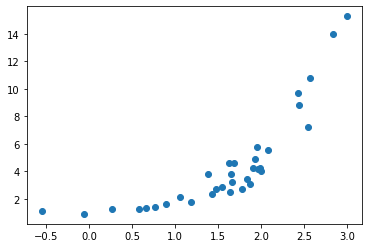

In [ ]:
plt.scatter(fitted6, residuals)

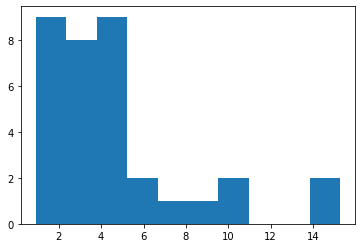

In [ ]:
plt.hist(residuals)
plt.show()